In [1]:
!pip install tensorflow==2.9.2  tensorflow_datasets==4.6.0
import tensorflow as tf
print('tensorflow version:', tf.__version__)
from tensorflow import keras
print('keras version:', keras.__version__)
tf.test.gpu_device_name()
tf.test.is_gpu_available()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tensorflow version: 2.9.2
keras version: 2.9.0
Num GPUs Available:  1


In [2]:
import os
import math
import numpy as np
import pandas as pd
import random
import cv2  # pip3 install opencv-python
from scipy import ndimage
import zipfile
import tensorflow_datasets as tfds
import os.path
import matplotlib.pyplot as plt
from matplotlib import cm
import random
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 2 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 11s (38.5 MB/s)
(Reading database ... 123942 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
f='/content/drive/MyDrive/BIGDataUPV/TFM/Alzheimer MRI Preprocessed Dataset/'
batch_size = 32
img_height = 128
img_width = 128

In [5]:
def imagetofile(folder,file,val_sp,subset):
  batch_size2 = 7800
  if(os.path.isfile(file+'.npy')):
    print("OK")
    x_train=np.load(file+'.npy')
    train_label=np.load(file+"_label.npy")
    return x_train,train_label
  else:
    train_ds= tf.keras.utils.image_dataset_from_directory(
      folder,
      validation_split=val_sp,
      subset=subset, seed=123,
      shuffle=False,
      image_size=(img_height, img_width),
      batch_size=batch_size2)
    x_train =None
    train_label=None
    for image, label in tfds.as_numpy(train_ds):
      x_train = image
      train_label=label
    x_train = x_train.astype('float32') / 255.0
    np.save(file, x_train)
    np.save(file+"_label", train_label)
    return x_train,train_label


In [6]:
folder=f+'train'
x_train,train_label=imagetofile(folder,f+'traindata',0.001,"training")

OK


In [7]:
folder2=f+'test'
x_test,test_label=imagetofile(folder2,f+'testdata',0.999,"validation")

OK


In [8]:
folder2=f+'val'
x_val,val_label=imagetofile(folder2,f+'valdata',0.999,"validation")

OK


In [9]:
def conv_block_1(x, filters, ks = (3, 3)):
  x = keras.layers.Conv2D(filters=filters,
                          kernel_size=ks,
                          strides=(1, 1),
                          padding='same',
                          activation=None)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  return x

def cnn_1(input_shape = None, num_labels = None):
    if input_shape is None:
        raise Exception('input_shape must be provided as a tuple, e.g., (28, 28)')
    if num_labels is None:
        raise Exception('num_labels must be provided as an integer')
    inputs = keras.Input(shape = input_shape)
    x = inputs
    #x = conv_block_1(x, filters=16, ks=(5, 5))
    x = conv_block_1(x, filters=16, ks=(3, 3))
    #x = conv_block_1(x, filters=32, ks=(3, 3))
    x = conv_block_1(x, filters=64, ks=(3, 3))
    x = keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = conv_block_1(x, filters=128, ks=(3, 3))
    x = conv_block_1(x, filters=256, ks=(3, 3))
    x = keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = conv_block_1(x, filters=256, ks=(3, 3))
    x = conv_block_1(x, filters=256, ks=(3, 3))
    x = keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = conv_block_1(x, filters=512, ks=(3, 3))
    x = conv_block_1(x, filters=512, ks=(3, 3))
    #x = keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    #x = conv_block_1(x, filters=1024, ks=(3, 3))
    #x = conv_block_1(x, filters=1024, ks=(3, 3))

    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(516)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    outputs = keras.layers.Dense(num_labels, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1.0e-5),
        loss='sparse_categorical_crossentropy',
        metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(),tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    model.summary()
    return model

In [10]:
class_names = ['Mild_Demented','Moderate_Demented','Non_Demented','Very_Mild_Demented']
print(class_names)
print(len(class_names))
print(x_train.shape[1])
print(train_label.shape)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
4
128
(5114,)


In [11]:
input_shape = (x_train.shape[1], x_train.shape[2], 3)
cnn = cnn_1(input_shape = input_shape, num_labels=len(class_names))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      9280      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                             

In [12]:
cnn.fit(x_train.reshape(x_train.shape), train_label,validation_data=(x_val,val_label) ,epochs=20, batch_size=100, shuffle=True)

Epoch 1/20
52/52 [==============================] - 36s 469ms/step - loss: 1.1995 - sparse_categorical_crossentropy: 1.1995 - sparse_categorical_accuracy: 0.5354 - val_loss: 1.2834 - val_sparse_categorical_crossentropy: 1.2834 - val_sparse_categorical_accuracy: 0.5016
Epoch 2/20
52/52 [==============================] - 22s 418ms/step - loss: 0.2283 - sparse_categorical_crossentropy: 0.2283 - sparse_categorical_accuracy: 0.9838 - val_loss: 1.2186 - val_sparse_categorical_crossentropy: 1.2186 - val_sparse_categorical_accuracy: 0.5016
Epoch 3/20
52/52 [==============================] - 22s 420ms/step - loss: 0.0863 - sparse_categorical_crossentropy: 0.0863 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2322 - val_sparse_categorical_crossentropy: 1.2322 - val_sparse_categorical_accuracy: 0.5016
Epoch 4/20
52/52 [==============================] - 22s 423ms/step - loss: 0.0500 - sparse_categorical_crossentropy: 0.0500 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2892 - val_sparse

In [13]:
cnn.evaluate(x_test, test_label, batch_size=100)

7/7 [==============================] - 2s 360ms/step - loss: 0.2039 - sparse_categorical_crossentropy: 0.2039 - sparse_categorical_accuracy: 0.9370


[0.20387104153633118, 0.20387104153633118, 0.937019944190979]

In [14]:
from matplotlib import pyplot
from sklearn.base import BaseEstimator
from sklearn import metrics
class MyArgmaxForPredictedLabels(BaseEstimator):
    def __init__(self, threshold = 0.5):
        self.threshold = threshold
        self._estimator_type = 'classifier'

    def fit(self, X, y):
        raise Exception('No fit implemented in this class')
        return self

    def predict(self, y_probs):
        assert type(y_probs) == np.ndarray
        assert len(y_probs.shape) == 1
        return y_probs

def show_results(y_true, y_pred, labels):
    _cm_ = metrics.confusion_matrix(y_true, y_pred)
    max_digits = int(math.log(_cm_.max())) + 1
    format_str = '%%%dd' % max_digits
    for i in range(_cm_.shape[0]):
        for j in range(_cm_.shape[1]):
            print(format_str % _cm_[i, j], end = ' ')
        print()
    print()

    print(metrics.classification_report(y_true, y_pred))
    #
    fig, axes = pyplot.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
    #fig.suptitle(title)
    #
    metrics.ConfusionMatrixDisplay.from_estimator(estimator = MyArgmaxForPredictedLabels(),
                          X = y_pred, y = y_true,
                          normalize = 'true', ax = axes[0],
                          labels = labels,
                          cmap = 'Blues') #, colorbar = False)
    #
    metrics.ConfusionMatrixDisplay.from_estimator(estimator = MyArgmaxForPredictedLabels(),
                          X = y_pred, y = y_true,
                          normalize = 'pred', ax = axes[1],
                          labels = labels,
                          cmap = 'Oranges') #, colorbar = False)
    #
    pyplot.tight_layout()
    pyplot.show()
    del fig

7/7 [==============================] - 1s 133ms/step
    88      0      1      1 
     0      7      0      0 
     5      3    300     12 
     6      1     12    215 

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        90
           1       0.64      1.00      0.78         7
           2       0.96      0.94      0.95       320
           3       0.94      0.92      0.93       234

    accuracy                           0.94       651
   macro avg       0.86      0.96      0.90       651
weighted avg       0.94      0.94      0.94       651



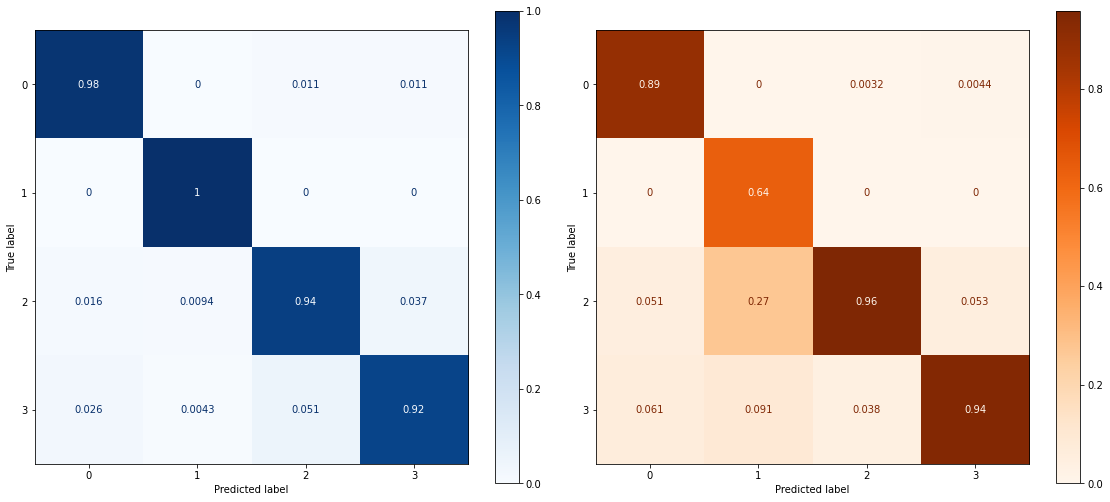

In [15]:
y_test_pred=cnn.predict(x_test, batch_size=100)
y_test_pred = y_test_pred.argmax(axis=1)

#print(test_label)
#print(y_test_pred)
#print(class_names)

show_results(y_true = test_label, y_pred = y_test_pred, labels = [0,1,2,3])

In [16]:
cnn.save(f+"cnnmodel")